# Raman Molmer-Sorensen


## Atomic Circuit


In [1]:
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    ParallelProtocol,  # noqa: F401
    Phonon,
    Pulse,
    SequentialProtocol,  # noqa: F401
    System,
    Transition,
)

downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 12.643e9,
    label="q1",
)
estate = Level(
    principal=6,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 811.29e12,
    label="e0",
)

transitions = [
    Transition(
        level1=downstate, level2=upstate, einsteinA=1, multipole="M1", label="q0->q1"
    ),
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
    Transition(
        level1=upstate, level2=estate, einsteinA=1, multipole="E1", label="q1->e0"
    ),
]


N = 4
ions = [
    Ion(
        mass=171,
        charge=1,
        position=[0, 0, i - (N - 1) / 2],
        levels=[downstate, upstate, estate],
        transitions=transitions,
    )
    for i in range(N)
]

eigenvector = []
for i in range(N):
    eigenvector.extend([1 / np.sqrt(N), 0, 0])
COM_x = Phonon(energy=2 * np.pi * 1e6, eigenvector=eigenvector)

system = System(
    ions=ions,
    modes=[COM_x],
)

beams = []
for i in range(N):
    beams.extend(
        [
            Beam(
                transition=transitions[1],
                rabi=np.sqrt(2) * 2 * np.pi * 1e9,
                detuning=2 * np.pi * 33.195e12,
                phase=0,
                polarization=[0, 1, 0],
                wavevector=[-1, 0, 0],
                target=i,
            ),
            Beam(
                transition=transitions[2],
                rabi=2 * np.pi * 1e9,
                detuning=2 * np.pi * (33.195e12 - 1.01e6),
                phase=0,
                polarization=[0, 1, 0],
                wavevector=[1, 0, 0],
                target=i,
            ),
            Beam(
                transition=transitions[2],
                rabi=2 * np.pi * 1e9,
                detuning=2 * np.pi * (33.195e12 + 1.01e6),
                phase=0,
                polarization=[0, 1, 0],
                wavevector=[1, 0, 0],
                target=i,
            ),
        ]
    )

protocol = ParallelProtocol(
    sequence=[Pulse(beam=beam, duration=4e-3) for beam in beams]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [2]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("5_ising.json", "w") as f:
    f.write(circuit_json)

In [3]:
with open("5_ising.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


### Compile


In [4]:
from oqd_compiler_infrastructure import Chain, Post

from oqd_trical.backend import DynamiqsBackend, QutipBackend  # noqa: F401
from oqd_trical.light_matter.compiler.approximate import (
    FirstOrderLambDickeApprox,  # noqa: F401
    RotatingReferenceFrame,
    RotatingWaveApprox,
    SecondOrderLambDickeApprox,  # noqa: F401
    adiabatic_elimination_factory,
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)

frame_specs = {
    f"E{i}": [
        0,
        2 * np.pi * 12.643e9,
        2 * np.pi * (811.29e12 + 33.195e12),
    ]
    for i in range(N)
}
frame_specs["P0"] = 2 * np.pi * 1e6

eliminated_specs = [(2, f"E{i}") for i in range(N)]

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 1e9)),
    canonicalize_emulator_circuit_factory(),
    adiabatic_elimination_factory(eliminated_specs=eliminated_specs),
    canonicalize_emulator_circuit_factory(),
    Post(FirstOrderLambDickeApprox(0.1)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

D:\work\Projects\TrICal\src\oqd_trical\light_matter\compiler\approximate.py:283: UserWarning: Caution required when using adiabatic elimination, system needs to be put in the appropriate rotating reference frame.
  warnings.warn(


In [5]:
from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(hilbert_space), "=" * 80, printer(backend.intermediate), sep="\n")

HilbertSpace
  - hilbert_space: dict
    - E0: set({0, 1})
    - E1: set({0, 1})
    - E2: set({0, 1})
    - E3: set({0, 1})
    - P0: set({0, 1, 2})
AtomicEmulatorCircuit
  - frame: Operator(79438311838.67151 * |1><1|_E0 @ I_E1 @ I_E2 @ I_E3 @ I_P0 + 79438311838.67151 * I_E0 @ |1><1|_E1 @ I_E2 @ I_E3 @ I_P0 + 79438311838.67151 * I_E0 @ I_E1 @ |1><1|_E2 @ I_E3 @ I_P0 + 79438311838.67151 * I_E0 @ I_E1 @ I_E2 @ |1><1|_E3 @ I_P0 + 6283185.307179586 * I_E0 @ I_E1 @ I_E2 @ I_E3 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(94640.53783972883 * |0><0|_E0 @ I_E1 @ I_E2 @ I_E3 @ I_P0 + (-2276.5587262665317 * exp(1j * (6283185.307179586 * t + -1.5707963267948966)) + -2276.5587262665317 * exp(1j * (6283185.307179586 * t + 1.5707963267948966))) * |0><0|_E0 @ I_E1 @ I_E2 @ I_E3 @ C_P0 + (2276.5587262665317 * exp(1j * (-6283185.307179586 * t + 1.5707963267948966)) + 2276.5587262665317 * exp(1j * (-6283185.307179586 * t + -1.5707963267948966))) * |0><0|_E

### Run


In [6]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-5,
)

10.0%. Run time:  24.24s. Est. time left: 00:00:03:38


20.0%. Run time:  45.16s. Est. time left: 00:00:03:00


30.0%. Run time:  67.43s. Est. time left: 00:00:02:37


40.0%. Run time:  93.25s. Est. time left: 00:00:02:19


50.0%. Run time: 120.48s. Est. time left: 00:00:02:00


60.0%. Run time: 140.95s. Est. time left: 00:00:01:33


70.0%. Run time: 160.20s. Est. time left: 00:00:01:08


80.0%. Run time: 181.54s. Est. time left: 00:00:00:45


90.0%. Run time: 202.93s. Est. time left: 00:00:00:22


100.0%. Run time: 224.07s. Est. time left: 00:00:00:00


Total run time: 224.07s


#### Results


In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

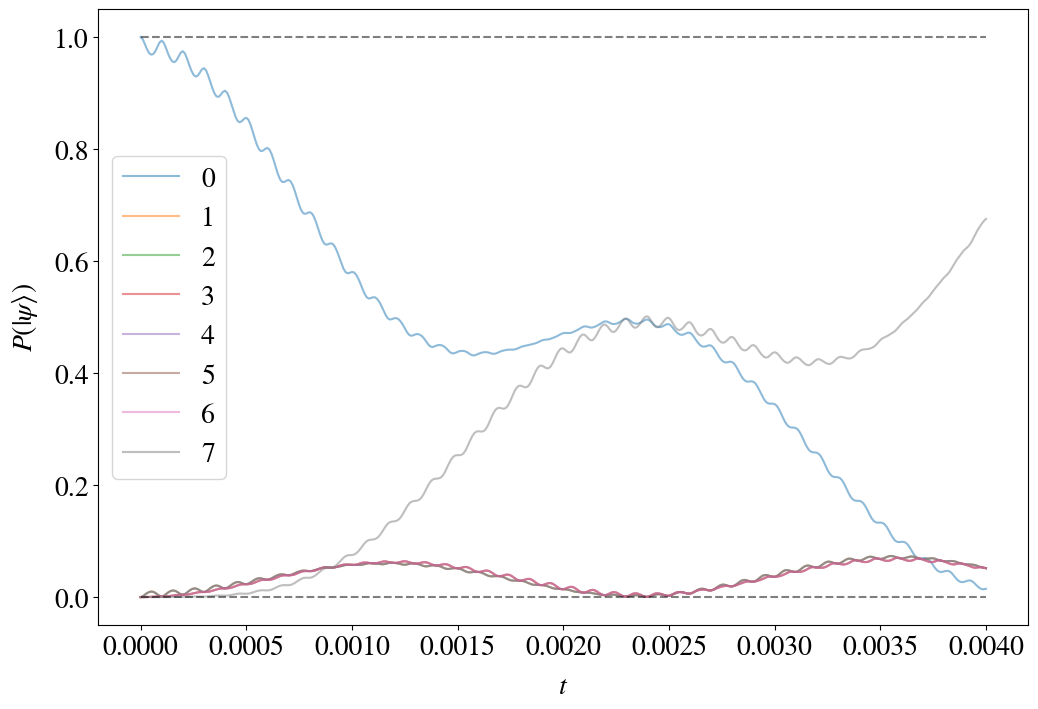

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)


state_labels = [0, 1, 2, 3, 4, 5, 6, 7]
plot_states = [
    [s.ptrace([0, 1, 2]).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(result["tspan"][k], plot_states, label=range(len(state_labels)), alpha=0.5)

ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

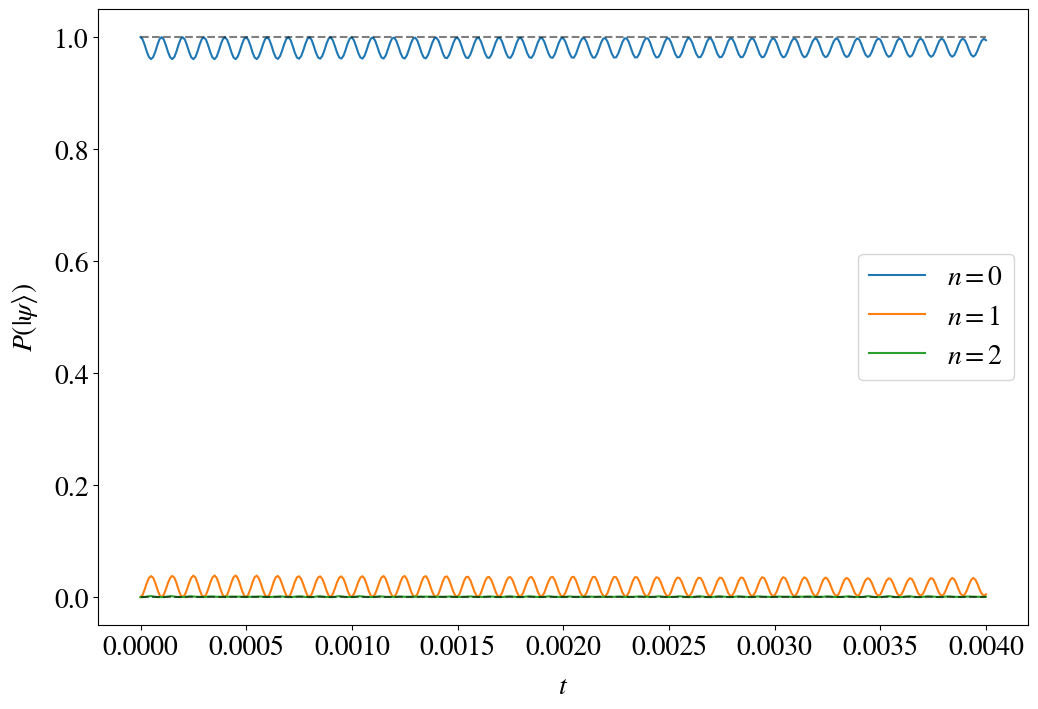

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(N).diag()[:] for s in result["states"][k]],
    label=[rf"$n={n}$" for n in range(fock_cutoff)],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()